<a href="https://colab.research.google.com/github/swadhinbiswas/machinelearning/blob/main/DEXBEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip3 install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
# Part 1: Setup and Configuration
import pandas as pd
import json
import glob
import os
import random
import numpy as np
import torch
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from datasets import Dataset, Audio, load_dataset
from transformers import WavLMForCTC, Wav2Vec2Processor, TrainingArguments, Trainer
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration class
class ASRConfig:
    def __init__(self):
        self.DATA_DIR = '/content/drive/MyDrive/AUDIO'  # Changed for Colab
        self.TRANSCRIPTION_TEXT = "১২টা বেজে গেছে"
        self.MODEL_NAME = "microsoft/wavlm-base-plus"
        self.OUTPUT_DIR = "/content/drive/MyDrive/wavlm-bengali-asr-finetuned" # Changed for Colab
        self.ANALYSIS_DIR = "/content/drive/MyDrive/wavlm-bengali-asr-analysis" # Changed for Colab
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.TARGET_SAMPLING_RATE = 16000
        self.N_FOLDS = 5
        self.RANDOM_SEED = 42

        # Training parameters
        self.BATCH_SIZE = 4
        self.GRADIENT_ACCUMULATION_STEPS = 2
        self.LEARNING_RATE = 3e-4
        self.CV_EPOCHS = 5
        self.FINAL_EPOCHS = 15
        self.WARMUP_STEPS = 200

def setup_environment(config):
    """Set up random seeds and create directories"""
    # Set random seeds for reproducibility
    random.seed(config.RANDOM_SEED)
    np.random.seed(config.RANDOM_SEED)
    torch.manual_seed(config.RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config.RANDOM_SEED)

    # Create directories
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    os.makedirs(config.ANALYSIS_DIR, exist_ok=True)
    os.makedirs(config.DATA_DIR, exist_ok=True) # Create data directory as well

    print("Environment setup complete")
    print(f"CUDA available: {torch.cuda.is_available()}")
    return config

# Initialize configuration
config = ASRConfig()
config = setup_environment(config)

Environment setup complete
CUDA available: True


--- Step 1: Data Preparation ---
Found 1080 audio files. Created 'transcripts.csv'.

--- Audio Data Analysis ---
Analyzing 100 randomly sampled files from 1080 total files

--- Audio Dataset Statistics ---
         duration  sampling_rate  channels  file_size_mb  max_amplitude  \
count  100.000000      100.00000     100.0    100.000000     100.000000   
mean     3.403199    46050.00000       1.0      0.522885       0.533329   
std      0.294795     1959.82374       0.0      0.148017       0.295745   
min      2.621146    44100.00000       1.0      0.240015       0.065338   
25%      3.150690    44100.00000       1.0      0.357424       0.269890   
50%      3.337143    46050.00000       1.0      0.574089       0.484764   
75%      3.669607    48000.00000       1.0      0.633684       0.773891   
max      3.971854    48000.00000       1.0      0.715412       1.000000   

       rms_energy  zero_crossing_rate  
count  100.000000          100.000000  
mean     0.062156            0.236925 

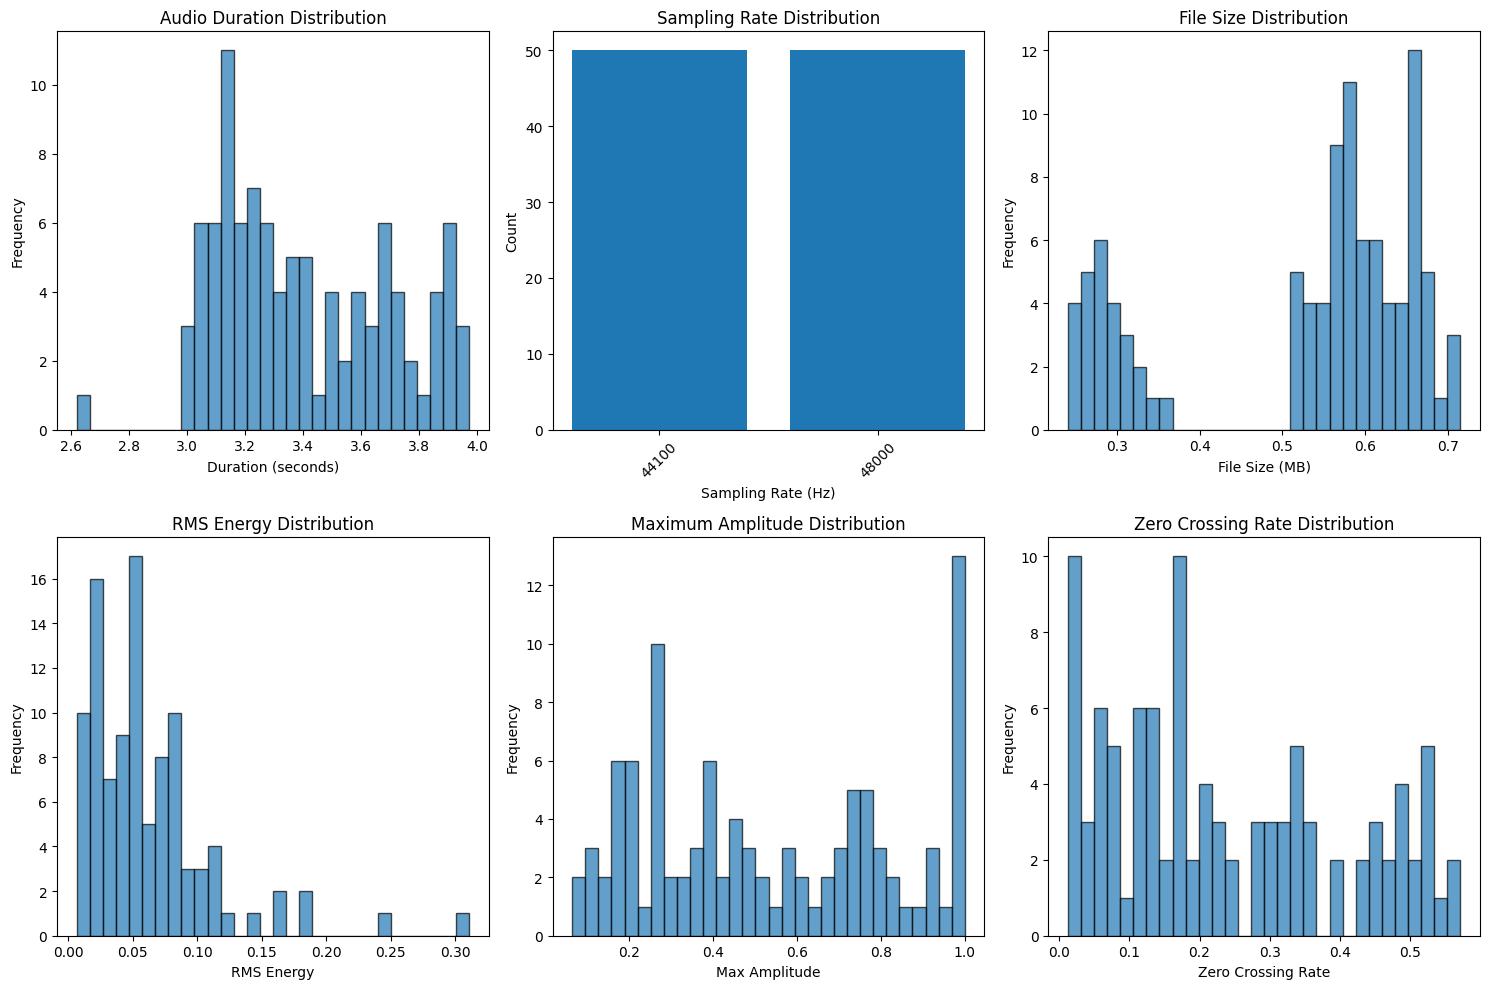

In [7]:
# Part 2: Data Preparation and Analysis

def prepare_dataset(config):
    """Find audio files and create transcriptions CSV"""
    print("--- Step 1: Data Preparation ---")

    # Find all .wav files recursively
    all_audio_paths = glob.glob(f'{config.DATA_DIR}/**/*.wav', recursive=True)

    if not all_audio_paths:
        raise FileNotFoundError(f"No .wav files found in '{config.DATA_DIR}'. Please check the path.")

    # Create a list of the same transcription for each audio file
    all_transcriptions = [config.TRANSCRIPTION_TEXT] * len(all_audio_paths)

    # Create the DataFrame
    labeled_data = {'file_path': all_audio_paths, 'transcription': all_transcriptions}
    df_labeled = pd.DataFrame(labeled_data)
    df_labeled.to_csv("transcripts.csv", index=False, encoding='utf-8')

    print(f"Found {len(df_labeled)} audio files. Created 'transcripts.csv'.")
    return df_labeled, all_audio_paths

def analyze_audio_files(file_paths, config, sample_size=100):
    """Analyze audio files to understand dataset characteristics"""
    print("\n--- Audio Data Analysis ---")

    analysis_data = {
        'file_path': [],
        'duration': [],
        'sampling_rate': [],
        'channels': [],
        'file_size_mb': [],
        'max_amplitude': [],
        'rms_energy': [],
        'zero_crossing_rate': []
    }

    # Sample files if dataset is large
    if len(file_paths) > sample_size:
        sample_files = random.sample(file_paths, sample_size)
        print(f"Analyzing {sample_size} randomly sampled files from {len(file_paths)} total files")
    else:
        sample_files = file_paths
        print(f"Analyzing all {len(file_paths)} files")

    for file_path in sample_files:
        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=None)

            # Calculate metrics
            duration = len(audio) / sr
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
            max_amp = np.max(np.abs(audio))
            rms = np.sqrt(np.mean(audio**2))
            zcr = np.mean(librosa.feature.zero_crossing_rate(audio))

            analysis_data['file_path'].append(file_path)
            analysis_data['duration'].append(duration)
            analysis_data['sampling_rate'].append(sr)
            analysis_data['channels'].append(1 if len(audio.shape) == 1 else audio.shape[0])
            analysis_data['file_size_mb'].append(file_size)
            analysis_data['max_amplitude'].append(max_amp)
            analysis_data['rms_energy'].append(rms)
            analysis_data['zero_crossing_rate'].append(zcr)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    return pd.DataFrame(analysis_data)

def create_audio_visualizations(audio_analysis_df, config):
    """Create visualizations for audio analysis"""
    if audio_analysis_df.empty:
        print("No audio analysis data to visualize")
        return

    # Display analysis results
    print("\n--- Audio Dataset Statistics ---")
    print(audio_analysis_df.describe())

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Duration distribution
    plt.subplot(2, 3, 1)
    plt.hist(audio_analysis_df['duration'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Audio Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')

    # Sampling rate distribution
    plt.subplot(2, 3, 2)
    sr_counts = audio_analysis_df['sampling_rate'].value_counts()
    plt.bar(sr_counts.index.astype(str), sr_counts.values)
    plt.title('Sampling Rate Distribution')
    plt.xlabel('Sampling Rate (Hz)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # File size distribution
    plt.subplot(2, 3, 3)
    plt.hist(audio_analysis_df['file_size_mb'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('File Size Distribution')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Frequency')

    # RMS Energy distribution
    plt.subplot(2, 3, 4)
    plt.hist(audio_analysis_df['rms_energy'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('RMS Energy Distribution')
    plt.xlabel('RMS Energy')
    plt.ylabel('Frequency')

    # Max Amplitude distribution
    plt.subplot(2, 3, 5)
    plt.hist(audio_analysis_df['max_amplitude'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Maximum Amplitude Distribution')
    plt.xlabel('Max Amplitude')
    plt.ylabel('Frequency')

    # Zero Crossing Rate distribution
    plt.subplot(2, 3, 6)
    plt.hist(audio_analysis_df['zero_crossing_rate'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Zero Crossing Rate Distribution')
    plt.xlabel('Zero Crossing Rate')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f'{config.ANALYSIS_DIR}/audio_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save analysis data
    audio_analysis_df.to_csv(f'{config.ANALYSIS_DIR}/audio_analysis.csv', index=False)

# Run data preparation and analysis
df_labeled, all_audio_paths = prepare_dataset(config)
audio_analysis_df = analyze_audio_files(all_audio_paths, config)
create_audio_visualizations(audio_analysis_df, config)

In [8]:
# Part 3: Vocabulary Creation and Model Setup

def create_vocabulary(df_labeled, config):
    """Generate a character-based vocabulary from the transcription"""
    print("\n--- Step 2: Vocabulary Creation ---")

    # Generate a character-based vocabulary from the transcription
    all_text = " ".join(df_labeled['transcription'].tolist())
    vocab_list = sorted(list(set(all_text)))  # Sort for consistency
    vocab_dict = {v: k for k, v in enumerate(vocab_list)}

    # The CTC blank token is often mapped to the space character
    if " " in vocab_dict:
        vocab_dict["|"] = vocab_dict.pop(" ")
    else:
        vocab_dict["|"] = len(vocab_dict)

    # Add special tokens
    vocab_dict["[UNK]"] = len(vocab_dict)
    vocab_dict["[PAD]"] = len(vocab_dict)

    # Save the custom vocabulary to a file
    vocab_file_path = "vocab.json"
    with open(vocab_file_path, 'w', encoding='utf-8') as vocab_file:
        json.dump(vocab_dict, vocab_file, ensure_ascii=False)

    print(f"Custom Bengali vocabulary with {len(vocab_dict)} tokens saved to: {vocab_file_path}")
    print("Vocabulary tokens:", list(vocab_dict.keys()))

    return vocab_dict, vocab_file_path

def load_model_and_processor(config, vocab_file_path):
    """Load the processor and model with custom vocabulary"""
    print("\n--- Step 3: Processor and Model Loading ---")

    # Load the processor, providing the path to your custom vocab file
    processor = Wav2Vec2Processor.from_pretrained(config.MODEL_NAME, vocab_file=vocab_file_path)

    # Load the model, correctly initializing a new CTC head
    model = WavLMForCTC.from_pretrained(
        config.MODEL_NAME,
        ignore_mismatched_sizes=True,  # This is crucial
        vocab_size=len(processor.tokenizer),
        ctc_loss_reduction="mean",
        pad_token_id=processor.tokenizer.pad_token_id,
    )

    print("Processor and WavLM model loaded successfully with a new CTC head.")
    print(f"Model vocabulary size: {len(processor.tokenizer)}")

    return processor, model

def create_dummy_noise(config):
    """Create dummy noise for data augmentation"""
    print("\n--- Step 4: Data Augmentation Setup ---")

    # Create dummy noise (in real projects, use diverse noise datasets like MUSAN)
    noise_sample_rate = config.TARGET_SAMPLING_RATE
    dummy_noise = np.random.normal(0, 0.05, size=int(10 * noise_sample_rate)).astype(np.float32)
    noise_file_path = "dummy_noise.wav"
    sf.write(noise_file_path, dummy_noise, noise_sample_rate)
    noise_paths = [noise_file_path]

    print(f"Created dummy noise file: {noise_file_path}")
    return noise_paths

def preprocess_with_augmentation_factory(processor, config, noise_paths):
    """Factory function to create preprocessing function with augmentation"""

    def preprocess_with_augmentation(batch):
        # Get audio array and sampling rate
        if isinstance(batch["file_path"], dict):
            audio_array = batch["file_path"]["array"]
            current_sr = batch["file_path"]["sampling_rate"]
        else:
            # Fallback for different data formats
            audio_array, current_sr = librosa.load(batch["file_path"], sr=config.TARGET_SAMPLING_RATE)

        # Resample if necessary
        if current_sr != config.TARGET_SAMPLING_RATE:
            audio_array = librosa.resample(y=audio_array, orig_sr=current_sr, target_sr=config.TARGET_SAMPLING_RATE)

        # Augmentation: Add random background noise (50% chance)
        if random.random() < 0.5 and len(noise_paths) > 0:
            try:
                noise_path = random.choice(noise_paths)
                noise, _ = librosa.load(noise_path, sr=config.TARGET_SAMPLING_RATE)

                if len(noise) >= len(audio_array):
                    start = random.randint(0, len(noise) - len(audio_array))
                    noise_segment = noise[start:start + len(audio_array)]
                else:
                    noise_segment = np.pad(noise, (0, len(audio_array) - len(noise)), mode='wrap')

                snr_db = random.uniform(5, 20)
                audio_power = np.mean(audio_array ** 2)
                noise_power = np.mean(noise_segment ** 2)
                if noise_power > 1e-6:  # Avoid division by zero
                    scale = np.sqrt(audio_power / (10**(snr_db/10) * noise_power))
                    audio_array += noise_segment * scale
            except Exception as e:
                print(f"Warning: Noise augmentation failed: {e}")

        # Process audio for the model
        batch["input_values"] = processor(audio_array, sampling_rate=config.TARGET_SAMPLING_RATE).input_values[0]

        # Process text transcriptions into labels
        with processor.as_target_processor():
            batch["labels"] = processor(batch["transcription"]).input_ids

        return batch

    return preprocess_with_augmentation

# Execute vocabulary and model setup
vocab_dict, vocab_file_path = create_vocabulary(df_labeled, config)
processor, model = load_model_and_processor(config, vocab_file_path)
noise_paths = create_dummy_noise(config)
preprocess_with_augmentation = preprocess_with_augmentation_factory(processor, config, noise_paths)


--- Step 2: Vocabulary Creation ---
Custom Bengali vocabulary with 12 tokens saved to: vocab.json
Vocabulary tokens: ['গ', 'ছ', 'জ', 'ট', 'ব', 'া', 'ে', '১', '২', '|', '[UNK]', '[PAD]']

--- Step 3: Processor and Model Loading ---


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of WavLMForCTC were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processor and WavLM model loaded successfully with a new CTC head.
Model vocabulary size: 16

--- Step 4: Data Augmentation Setup ---


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Created dummy noise file: dummy_noise.wav


In [9]:
!pip3 install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.0 MB/s eta 0:00:00


In [10]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.0 MB/s eta 0:00:00


In [11]:
# FIXED Part 4: Dataset Processing and Metrics

def prepare_final_dataset(config, preprocess_with_augmentation):
    """Load and process the dataset for training"""
    print("\n--- Step 5: Dataset Preparation ---")

    # Load from CSV without casting to Audio type to avoid torchcodec dependency
    labeled_dataset = load_dataset('csv', data_files={'train': 'transcripts.csv'})['train']

    # Don't cast to Audio type - we'll handle audio loading in preprocessing
    print(f"Loaded dataset with {len(labeled_dataset)} samples")

    # Process dataset with error handling
    processed_samples = []
    failed_samples = 0

    for i, sample in enumerate(labeled_dataset):
        try:
            processed_sample = preprocess_with_augmentation(sample)
            processed_samples.append(processed_sample)
        except Exception as e:
            print(f"Failed to process sample {i}: {e}")
            failed_samples += 1
            continue

    if failed_samples > 0:
        print(f"Warning: {failed_samples} samples failed to process and were skipped")

    # Convert back to dataset
    if processed_samples:
        # Get keys from first sample
        keys = list(processed_samples[0].keys())
        final_data = {key: [sample[key] for sample in processed_samples] for key in keys}
        final_dataset = Dataset.from_dict(final_data)
    else:
        raise RuntimeError("No samples were successfully processed!")

    print(f"Successfully processed dataset size: {len(final_dataset)} samples")
    return final_dataset

@dataclass
class DataCollatorCTCWithPadding:
    """Data collator for padding CTC inputs"""
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(label_features, padding=self.padding, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

def calculate_wer_fixed(predictions, references):
    """
    FIXED: Calculate Word Error Rate (WER) using available libraries or simple approximation
    This version doesn't depend on global variables
    """

    # Method 1: Try to use the evaluate library
    try:
        import evaluate
        wer_metric = evaluate.load("wer")
        result = wer_metric.compute(predictions=predictions, references=references)
        print("Using 'evaluate' library for WER calculation")
        return result
    except ImportError:
        print("'evaluate' library not available, trying Levenshtein...")
    except Exception as e:
        print(f"Error with evaluate library: {e}, trying Levenshtein...")

    # Method 2: Try Levenshtein distance
    try:
        import Levenshtein
        total_words = 0
        total_errors = 0

        for pred, ref in zip(predictions, references):
            pred_words = pred.split()
            ref_words = ref.split()

            total_words += len(ref_words)
            if len(ref_words) == 0:
                continue

            # Calculate word-level Levenshtein distance
            errors = Levenshtein.distance(' '.join(pred_words), ' '.join(ref_words))
            total_errors += errors

        wer = total_errors / total_words if total_words > 0 else 0.0
        print("Using Levenshtein distance for WER calculation")
        return wer

    except ImportError:
        print("Levenshtein library not available, using character-level fallback...")
    except Exception as e:
        print(f"Error with Levenshtein: {e}, using character-level fallback...")

    # Method 3: Simple character-level accuracy as fallback
    print("Using character-level accuracy fallback for WER calculation")
    total_chars = 0
    correct_chars = 0

    for pred, ref in zip(predictions, references):
        min_len = min(len(pred), len(ref))
        for i in range(min_len):
            total_chars += 1
            if pred[i] == ref[i]:
                correct_chars += 1

        # Account for length differences
        total_chars += abs(len(pred) - len(ref))

    accuracy = correct_chars / total_chars if total_chars > 0 else 0.0
    return 1.0 - accuracy  # Convert accuracy to error rate

def compute_metrics_factory_fixed(processor):
    """
    FIXED: Factory function to create metrics computation function
    Uses the fixed calculate_wer function
    """

    def compute_metrics(pred):
        pred_logits = pred.predictions
        pred_ids = np.argmax(pred_logits, axis=-1)

        # Replace -100 with pad token id
        pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

        # Decode predictions and labels
        pred_str = processor.batch_decode(pred_ids)
        label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

        # Use the fixed WER calculation function
        wer = calculate_wer_fixed(pred_str, label_str)
        return {"wer": wer}

    return compute_metrics

# Execute dataset processing with FIXED functions
print("Executing FIXED dataset processing...")
final_dataset = prepare_final_dataset(config, preprocess_with_augmentation)
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
compute_metrics = compute_metrics_factory_fixed(processor)  # Use the FIXED version

print("✅ Dataset processing completed with FIXED metrics calculation!")

Executing FIXED dataset processing...

--- Step 5: Dataset Preparation ---


Generating train split: 0 examples [00:00, ? examples/s]

Loaded dataset with 1080 samples
Successfully processed dataset size: 1080 samples
✅ Dataset processing completed with FIXED metrics calculation!


In [12]:
!pip install jiwer

Dataset size: 1080 - Performing 5-fold cross-validation...

--- Step 6: Cross-Validation (5 folds) ---

--- Cross-Validation Fold 1/5 ---
Train samples: 864, Validation samples: 216


Some weights of WavLMForCTC were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Wer
50,8.675700,7.344101,1.000000
100,3.046300,2.480980,1.000000
150,2.471700,2.314792,1.000000
200,2.313100,2.303713,1.000000
250,2.319800,2.339048,1.000000
300,2.299200,2.311339,1.000000
350,2.296300,2.296442,1.000000
400,2.295100,2.296324,1.000000
450,2.297600,2.316188,1.000000
500,2.298300,2.310443,1.000000


Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation


Using 'evaluate' library for WER calculation
Fold 1 Results:
  Train Loss: 4.2628
  Eval Loss: 7.3441
  Eval WER: 1.0000
  Training Time: 621.77 seconds

--- Cross-Validation Fold 2/5 ---
Train samples: 864, Validation samples: 216


Some weights of WavLMForCTC were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Wer
50,7.954000,6.754992,1.000000
100,3.055700,2.462141,1.000000
150,2.456600,2.316876,1.000000
200,2.308800,2.302332,1.000000
250,2.493500,2.352916,1.000000
300,2.304600,2.302162,1.000000
350,2.295100,2.295626,1.000000
400,2.295900,2.295505,1.000000
450,2.298000,2.320006,1.000000
500,2.295900,2.309649,1.000000


Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation


Using 'evaluate' library for WER calculation
Fold 2 Results:
  Train Loss: 4.1167
  Eval Loss: 6.7550
  Eval WER: 1.0000
  Training Time: 531.62 seconds

--- Cross-Validation Fold 3/5 ---
Train samples: 864, Validation samples: 216


Some weights of WavLMForCTC were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Wer
50,8.332200,7.044065,1.000000
100,3.104000,2.465621,1.000000
150,2.338700,2.305506,1.000000
200,2.380700,2.301780,1.000000
250,2.310300,2.358248,1.000000
300,2.335600,2.296351,1.000000
350,2.296000,2.295566,1.000000
400,2.297200,2.295767,1.000000
450,2.297600,2.319687,1.000000
500,2.296200,2.309671,1.000000


Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation


Using 'evaluate' library for WER calculation
Fold 3 Results:
  Train Loss: 4.1608
  Eval Loss: 7.0441
  Eval WER: 1.0000
  Training Time: 595.02 seconds

--- Cross-Validation Fold 4/5 ---
Train samples: 864, Validation samples: 216


Some weights of WavLMForCTC were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Wer
50,7.481800,6.356626,1.000000
100,2.952400,2.432594,1.000000
150,2.444100,2.315832,1.000000
200,2.331000,2.308002,1.000000
250,2.572600,2.359030,1.000000
300,2.303000,2.299374,1.000000
350,2.294300,2.296280,1.000000
400,2.296300,2.296107,1.000000
450,2.296700,2.320518,1.000000
500,2.296300,2.311933,1.000000


Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation


Using 'evaluate' library for WER calculation
Fold 4 Results:
  Train Loss: 4.0239
  Eval Loss: 6.3566
  Eval WER: 1.0000
  Training Time: 685.17 seconds

--- Cross-Validation Fold 5/5 ---
Train samples: 864, Validation samples: 216


Some weights of WavLMForCTC were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Wer
50,7.418200,6.309479,1.000000
100,2.966400,2.435576,1.000000
150,2.375400,2.315697,1.000000
200,2.421700,2.306543,1.000000
250,2.393200,2.357904,1.000000
300,2.313500,2.296385,1.000000
350,2.293000,2.295543,1.000000
400,2.296900,2.295482,1.000000
450,2.296800,2.326155,1.000000
500,2.296100,2.310285,1.000000


Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation
Using 'evaluate' library for WER calculation


Using 'evaluate' library for WER calculation
Fold 5 Results:
  Train Loss: 4.0271
  Eval Loss: 6.3095
  Eval WER: 1.0000
  Training Time: 610.49 seconds

--- Cross-Validation Results Summary ---
   fold  train_loss  eval_loss  eval_wer  training_time
0     1    4.262823   7.344101       1.0     621.770845
1     2    4.116723   6.754996       1.0     531.624680
2     3    4.160768   7.044069       1.0     595.024371
3     4    4.023856   6.356623       1.0     685.168194
4     5    4.027138   6.309473       1.0     610.487333

--- Cross-Validation Statistics ---
Mean WER: 1.0000 ± 0.0000
Mean Eval Loss: 6.7619 ± 0.4437
Mean Training Time: 608.82 ± 55.11 seconds


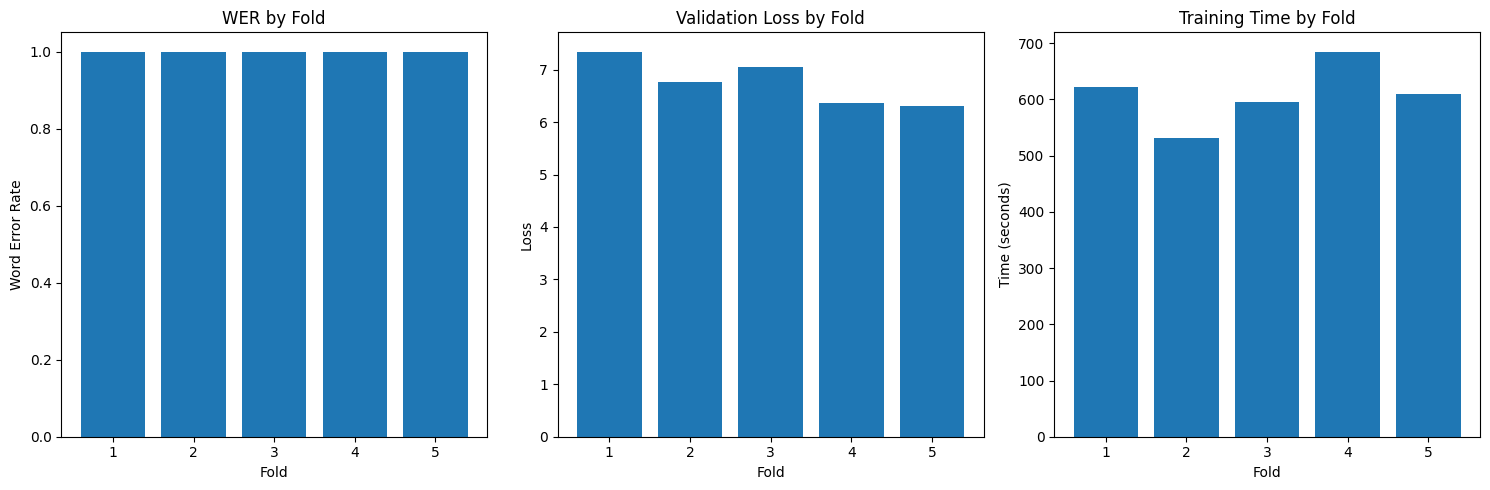

In [13]:
# Part 5: Cross-Validation Implementation

def perform_cross_validation(dataset, config, processor, data_collator, compute_metrics, n_folds=5):
    """Perform k-fold cross-validation"""
    print(f"\n--- Step 6: Cross-Validation ({n_folds} folds) ---")

    cv_results = {
        'fold': [],
        'train_loss': [],
        'eval_loss': [],
        'eval_wer': [],
        'training_time': []
    }

    # Convert dataset to indices for KFold
    indices = list(range(len(dataset)))
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=config.RANDOM_SEED)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n--- Cross-Validation Fold {fold + 1}/{n_folds} ---")

        # Create train and validation datasets for this fold
        train_dataset = dataset.select(train_idx)
        eval_dataset = dataset.select(val_idx)

        print(f"Train samples: {len(train_dataset)}, Validation samples: {len(eval_dataset)}")

        # Create a fresh model for each fold
        fold_model = WavLMForCTC.from_pretrained(
            config.MODEL_NAME,
            ignore_mismatched_sizes=True,
            vocab_size=len(processor.tokenizer),
            ctc_loss_reduction="mean",
            pad_token_id=processor.tokenizer.pad_token_id,
        )

        # Training arguments for cross-validation (fewer epochs to save time)
        training_args = TrainingArguments(
            output_dir=f"{config.OUTPUT_DIR}/fold_{fold + 1}",
            group_by_length=True,
            per_device_train_batch_size=config.BATCH_SIZE,
            gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
            eval_strategy="steps",
            num_train_epochs=config.CV_EPOCHS,
            fp16=torch.cuda.is_available(),
            save_steps=50,
            eval_steps=50,
            logging_steps=10,
            learning_rate=config.LEARNING_RATE,
            warmup_steps=100,
            save_total_limit=1,
            push_to_hub=False,
            load_best_model_at_end=True,
            metric_for_best_model="wer",
            greater_is_better=False,
            remove_unused_columns=False,  # Important for audio data
            dataloader_pin_memory=False,  # Avoid memory issues
            report_to=[],  # Disable wandb and other logging services
            run_name=f"fold_{fold + 1}",  # Set unique run name
        )

        # Initialize trainer for this fold
        trainer = Trainer(
            model=fold_model,
            data_collator=data_collator,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=processor.feature_extractor,
        )

        # Train the model
        start_time = datetime.now()
        try:
            train_result = trainer.train()
            training_time = (datetime.now() - start_time).total_seconds()

            # Evaluate the model
            eval_result = trainer.evaluate()

            # Store results
            cv_results['fold'].append(fold + 1)
            cv_results['train_loss'].append(train_result.training_loss)
            cv_results['eval_loss'].append(eval_result['eval_loss'])
            cv_results['eval_wer'].append(eval_result['eval_wer'])
            cv_results['training_time'].append(training_time)

            print(f"Fold {fold + 1} Results:")
            print(f"  Train Loss: {train_result.training_loss:.4f}")
            print(f"  Eval Loss: {eval_result['eval_loss']:.4f}")
            print(f"  Eval WER: {eval_result['eval_wer']:.4f}")
            print(f"  Training Time: {training_time:.2f} seconds")

        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
            # Store error results
            cv_results['fold'].append(fold + 1)
            cv_results['train_loss'].append(float('inf'))
            cv_results['eval_loss'].append(float('inf'))
            cv_results['eval_wer'].append(1.0)  # Worst case WER
            cv_results['training_time'].append(0)

        # Clean up to save memory
        del fold_model, trainer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return pd.DataFrame(cv_results)

def visualize_cv_results(cv_results_df, config):
    """Create visualizations for cross-validation results"""
    if cv_results_df is None or cv_results_df.empty:
        return

    # Display cross-validation results
    print("\n--- Cross-Validation Results Summary ---")
    print(cv_results_df)

    print("\n--- Cross-Validation Statistics ---")
    print(f"Mean WER: {cv_results_df['eval_wer'].mean():.4f} ± {cv_results_df['eval_wer'].std():.4f}")
    print(f"Mean Eval Loss: {cv_results_df['eval_loss'].mean():.4f} ± {cv_results_df['eval_loss'].std():.4f}")
    print(f"Mean Training Time: {cv_results_df['training_time'].mean():.2f} ± {cv_results_df['training_time'].std():.2f} seconds")

    # Save cross-validation results
    cv_results_df.to_csv(f'{config.ANALYSIS_DIR}/cross_validation_results.csv', index=False)

    # Visualize cross-validation results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.bar(cv_results_df['fold'], cv_results_df['eval_wer'])
    plt.title('WER by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Word Error Rate')

    plt.subplot(1, 3, 2)
    plt.bar(cv_results_df['fold'], cv_results_df['eval_loss'])
    plt.title('Validation Loss by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 3)
    plt.bar(cv_results_df['fold'], cv_results_df['training_time'])
    plt.title('Training Time by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Time (seconds)')

    plt.tight_layout()
    plt.savefig(f'{config.ANALYSIS_DIR}/cross_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Perform cross-validation if dataset is large enough
cv_results_df = None
if len(final_dataset) >= config.N_FOLDS * 2:  # At least 2 samples per fold
    print(f"Dataset size: {len(final_dataset)} - Performing {config.N_FOLDS}-fold cross-validation...")
    cv_results_df = perform_cross_validation(
        final_dataset, config, processor, data_collator, compute_metrics, config.N_FOLDS
    )
    visualize_cv_results(cv_results_df, config)
else:
    print(f"Dataset size: {len(final_dataset)} - Too small for {config.N_FOLDS}-fold cross-validation. Skipping CV.")
    print("Training will proceed with full dataset.")

In [16]:
# Part 6: Final Model Training and Evaluation

def train_final_model(dataset, config, processor, model, data_collator, compute_metrics):
    """Train the final model on the entire dataset"""
    print("\n--- Step 7: Final Model Training ---")

    # Training arguments for final model
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        group_by_length=True,
        per_device_train_batch_size=config.BATCH_SIZE,
        gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
        eval_strategy="epoch",
        num_train_epochs=config.FINAL_EPOCHS,
        gradient_checkpointing=True,
        fp16=torch.cuda.is_available(),
        save_steps=100,
        eval_steps=100,
        logging_steps=20,
        learning_rate=config.LEARNING_RATE,
        weight_decay=0.005,
        warmup_steps=config.WARMUP_STEPS,
        save_total_limit=2,
        push_to_hub=False,
        load_best_model_at_end=False,
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        report_to=[],
        run_name="final_training",
    )

    # Split dataset for final training (80% train, 20% validation)
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    indices = list(range(dataset_size))
    random.shuffle(indices)

    train_indices = indices[:train_size]
    eval_indices = indices[train_size:]

    train_dataset = dataset.select(train_indices)
    eval_dataset = dataset.select(eval_indices)

    print(f"Final training - Train samples: {len(train_dataset)}, Validation samples: {len(eval_dataset)}")

    # Initialize trainer
    trainer = Trainer(
        model=model,
        data_collator=data_collator,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor.feature_extractor,
    )

    # Train the model
    print("Starting final model training...")
    start_time = datetime.now()

    try:
        train_result = trainer.train()
        training_time = (datetime.now() - start_time).total_seconds()

        # Evaluate the final model
        eval_result = trainer.evaluate()

        print(f"\nFinal Training Results:")
        print(f"  Train Loss: {train_result.training_loss:.4f}")
        print(f"  Eval Loss: {eval_result['eval_loss']:.4f}")
        print(f"  Eval WER: {eval_result['eval_wer']:.4f}")
        print(f"  Training Time: {training_time:.2f} seconds")

        # Save the final model
        trainer.save_model()
        processor.save_pretrained(config.OUTPUT_DIR)

        print(f"Final model saved to: {config.OUTPUT_DIR}")

        return trainer, train_result, eval_result, training_time

    except Exception as e:
        print(f"Error during final training: {e}")
        return None, None, None, 0

def test_model_inference(processor, model, config, test_audio_path=None):
    """Test the trained model with inference"""
    print("\n--- Step 8: Model Inference Testing ---")

    if test_audio_path is None:
        # Use the first audio file from the dataset for testing
        test_audio_path = glob.glob(f'{config.DATA_DIR}/**/*.wav', recursive=True)[0]

    print(f"Testing model with audio file: {test_audio_path}")

    try:
        # Load and preprocess audio
        audio_array, sr = librosa.load(test_audio_path, sr=config.TARGET_SAMPLING_RATE)

        # Process audio for inference
        inputs = processor(audio_array, sampling_rate=config.TARGET_SAMPLING_RATE, return_tensors="pt")

        # Move to appropriate device
        inputs = {key: value.to(config.DEVICE) for key, value in inputs.items()}
        model = model.to(config.DEVICE)

        # Perform inference
        with torch.no_grad():
            logits = model(**inputs).logits

        # Decode the predicted ids to text
        predicted_ids = torch.argmax(logits, dim=-1)
        predicted_text = processor.batch_decode(predicted_ids)[0]

        print(f"Expected transcription: {config.TRANSCRIPTION_TEXT}")
        print(f"Predicted transcription: {predicted_text}")

        # Calculate similarity (simple character-level)
        expected = config.TRANSCRIPTION_TEXT
        predicted = predicted_text

        # Simple similarity calculation
        min_len = min(len(expected), len(predicted))
        matches = sum(1 for i in range(min_len) if expected[i] == predicted[i])
        similarity = matches / max(len(expected), len(predicted)) if max(len(expected), len(predicted)) > 0 else 0

        print(f"Character-level similarity: {similarity:.2%}")

        return predicted_text, similarity

    except Exception as e:
        print(f"Error during inference testing: {e}")
        return None, 0

def create_training_summary(config, cv_results_df=None, final_results=None):
    """Create a comprehensive training summary"""
    print("\n--- Training Summary ---")

    summary = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_name': config.MODEL_NAME,
        'transcription_text': config.TRANSCRIPTION_TEXT,
        'dataset_size': None,
        'cross_validation_results': None,
        'final_training_results': None
    }

    # Add dataset information
    try:
        df_transcripts = pd.read_csv('transcripts.csv')
        summary['dataset_size'] = len(df_transcripts)
    except:
        pass

    # Add cross-validation results
    if cv_results_df is not None and not cv_results_df.empty:
        summary['cross_validation_results'] = {
            'mean_wer': cv_results_df['eval_wer'].mean(),
            'std_wer': cv_results_df['eval_wer'].std(),
            'mean_eval_loss': cv_results_df['eval_loss'].mean(),
            'std_eval_loss': cv_results_df['eval_loss'].std(),
            'mean_training_time': cv_results_df['training_time'].mean()
        }

    # Add final training results
    if final_results is not None:
        train_result, eval_result, training_time = final_results
        if train_result is not None and eval_result is not None:
            summary['final_training_results'] = {
                'train_loss': train_result.training_loss,
                'eval_loss': eval_result['eval_loss'],
                'eval_wer': eval_result['eval_wer'],
                'training_time': training_time
            }

    # Save summary
    summary_path = f'{config.ANALYSIS_DIR}/training_summary.json'
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print(f"Training summary saved to: {summary_path}")

    # Print summary
    print("\n=== FINAL SUMMARY ===")
    print(f"Model: {summary['model_name']}")
    print(f"Dataset Size: {summary['dataset_size']}")
    print(f"Transcription: {summary['transcription_text']}")

    if summary['cross_validation_results']:
        cv = summary['cross_validation_results']
        print(f"\nCross-Validation Results:")
        print(f"  Mean WER: {cv['mean_wer']:.4f} ± {cv['std_wer']:.4f}")
        print(f"  Mean Eval Loss: {cv['mean_eval_loss']:.4f} ± {cv['std_eval_loss']:.4f}")

    if summary['final_training_results']:
        final = summary['final_training_results']
        print(f"\nFinal Training Results:")
        print(f"  Train Loss: {final['train_loss']:.4f}")
        print(f"  Eval Loss: {final['eval_loss']:.4f}")
        print(f"  Eval WER: {final['eval_wer']:.4f}")

    return summary

# Execute final training and evaluation
print("Starting final model training phase...")

# Train the final model
final_trainer, train_result, eval_result, training_time = train_final_model(
    final_dataset, config, processor, model, data_collator, compute_metrics
)

# Test model inference
if final_trainer is not None:
    predicted_text, similarity = test_model_inference(processor, final_trainer.model, config)

# Create comprehensive summary
final_results = (train_result, eval_result, training_time) if train_result is not None else None
training_summary = create_training_summary(config, cv_results_df, final_results)

print("\n🎉 Training pipeline completed successfully!")
print(f"📁 Model saved to: {config.OUTPUT_DIR}")
print(f"📊 Analysis saved to: {config.ANALYSIS_DIR}")

Starting final model training phase...

--- Step 7: Final Model Training ---
Final training - Train samples: 864, Validation samples: 216
Starting final model training...
Error during final training: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 2936 has 14.73 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 215.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- Training Summary ---
Training summary saved to: /content/drive/MyDrive/wavlm-bengali-asr-analysis/training_summary.json

=== FINAL SUMMARY ===
Model: microsoft/wavlm-base-plus
Dataset Size: 1080
Transcription: ১২টা বেজে গেছে

Cross-Validation Results:
  Mean WER: 1.0000 ± 0.0000
